## numpy를 이용한 신경망 구성

이 튜토리얼에서는 3차 다항식(third order polynomial)을 사용하여 y=sin(x) 에 근사(fit)하는 문제를 다뤄보겠습니다. 신경망은 4개의 매개변수를 가지며, 정답과 신경망이 예측한 결과 사이의 유클리드 거리(Euclidean distance)를 최소화하여 임의의 값을 근사할 수 있도록 경사하강법(gradient descent)을 사용하여 학습하겠습니다.

In [1]:
import torch
import math


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # GPU에서 실행하려면 이 주석을 제거하세요

# 무작위로 입력과 출력 데이터를 생성합니다
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# 무작위로 가중치를 초기화합니다
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # 순전파 단계: 예측값 y를 계산합니다
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # 손실(loss)을 계산하고 출력합니다
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # 손실에 따른 a, b, c, d의 변화도(gradient)를 계산하고 역전파합니다.
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # 가중치를 갱신합니다.
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 184.83404541015625
199 126.19790649414062
299 87.14308166503906
399 61.1112174987793
499 43.75119400024414
599 32.16815948486328
699 24.435626983642578
799 19.270484924316406
899 15.818317413330078
999 13.50961685180664
1099 11.964560508728027
1199 10.929871559143066
1299 10.236501693725586
1399 9.771459579467773
1499 9.459359169006348
1599 9.249716758728027
1699 9.108787536621094
1799 9.013959884643555
1899 8.950096130371094
1999 8.907047271728516
Result: y = -0.005818014033138752 + 0.8492318987846375 x + 0.0010037020547315478 x^2 + -0.09226230531930923 x^3


## Autograd

In [2]:
import torch
import math

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # GPU에서 실행하려면 이 주석을 제거하세요

# 입력값과 출력값을 갖는 텐서들을 생성합니다.
# requires_grad=False가 기본값으로 설정되어 역전파 단계 중에 이 텐서들에 대한 변화도를
# 계산할 필요가 없음을 나타냅니다.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# 가중치를 갖는 임의의 텐서를 생성합니다. 3차 다항식이므로 4개의 가중치가 필요합니다:
# y = a + b x + c x^2 + d x^3
# requires_grad=True로 설정하여 역전파 단계 중에 이 텐서들에 대한 변화도를 계산할 필요가 
# 있음을 나타냅니다.
a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # 순전파 단계: 텐서들 간의 연산을 사용하여 예측값 y를 계산합니다.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # 텐서들간의 연산을 사용하여 손실(loss)을 계싼하고 출력합니다.
    # 이 때 손실은 (1,) shape을 갖는 텐서입니다.
    # loss.item() 으로 손실이 갖고 있는 스칼라 값을 가져올 수 있습니다.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # autograd 를 사용하여 역전파 단계를 계산합니다. 이는 requires_grad=True를 갖는
    # 모든 텐서들에 대한 손실의 변화도를 계산합니다. 
    # 이후 a.grad와 b.grad, c.grad, d.grad는 각각 a, b, c, d에 대한 손실의 변화도를
    # 갖는 텐서가 됩니다.
    loss.backward()

    # 경사하강법(gradient descent)를 사용하여 가중치를 직접 갱신합니다.
    # torch.no_grad()로 감싸는 이유는, 가중치들이 requires_grad=True 지만
    # autograd에서는 이를 추적하지 않을 것이기 때문입니다.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # 가중치 갱신 후에는 변화도를 직접 0으로 만듭니다.
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 749.682373046875
199 506.9913024902344
299 344.0918884277344
399 234.6625213623047
499 161.090576171875
599 111.58364868164062
699 78.24031829833984
799 55.762672424316406
899 40.59541320800781
999 30.35104751586914
1099 23.42483139038086
1199 18.73714828491211
1299 15.561164855957031
1399 13.407160758972168
1499 11.944672584533691
1599 10.950599670410156
1699 10.274150848388672
1799 9.81332778930664
1899 9.499037742614746
1999 9.284446716308594
Result: y = -0.016735432669520378 + 0.8424112200737 x + 0.002887140726670623 x^2 + -0.0912921205163002 x^3


내부적으로, autograd의 기본(primitive) 연산자는 실제로 텐서를 조작하는 2개의 함수입니다. forward 함수는 입력 텐서로부터 출력 텐서를 계산합니다. backward 함수는 어떤 스칼라 값에 대한 출력 텐서의 변화도(gradient)를 전달받고, 동일한 스칼라 값에 대한 입력 텐서의 변화도를 계산합니다.



## torch의 nn 모듈

In [3]:
import torch
import math

# 입력값과 출력값을 갖는 텐서들을 생성합니다.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# 이 예제에서, 출력 y는 (x, x^2, x^3)의 선형 함수이므로, 선형 계층 신경망으로 간주할 수 있습니다.
# (x, x^2, x^3)를 위한 텐서를 준비합니다.
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# 위 코드에서, x.unsqueeze(-1)은 (2000, 1)의 shape을, p는 (3,)의 shape을 가지므로,
# 이 경우 브로드캐스트(broadcast)가 적용되어 (2000, 3)의 shape을 갖는 텐서를 얻습니다.

# nn 패키지를 사용하여 모델을 순차적 계층(sequence of layers)으로 정의합니다.
# nn.Sequential은 다른 Module을 포함하는 Module로, 포함되는 Module들을 순차적으로 적용하여 
# 출력을 생성합니다. 각각의 Linear Module은 선형 함수(linear function)를 사용하여 입력으로부터
# 출력을 계산하고, 내부 Tensor에 가중치와 편향을 저장합니다.
# Flatten 계층은 선형 계층의 출력을 `y` 의 shape과 맞도록(match) 1D 텐서로 폅니다(flatten).
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

# 또한 nn 패키지에는 주로 사용되는 손실 함수(loss function)들에 대한 정의도 포함되어 있습니다;
# 여기에서는 평균 제곱 오차(MSE; Mean Squared Error)를 손실 함수로 사용하겠습니다.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-6
for t in range(2000):

    # 순전파 단계: x를 모델에 전달하여 예측값 y를 계산합니다. Module 객체는 __call__ 연산자를 
    # 덮어써서(override) 함수처럼 호출할 수 있도록 합니다. 이렇게 함으로써 입력 데이터의 텐서를 Module에 전달하여
    # 출력 데이터의 텐서를 생성합니다.
    y_pred = model(xx)

    # 손실을 계산하고 출력합니다. 예측한 y와 정답인 y를 갖는 텐서들을 전달하고,
    # 손실 함수는 손실(loss)을 갖는 텐서를 반환합니다.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # 역전파 단계를 실행하기 전에 변화도(gradient)를 0으로 만듭니다.
    model.zero_grad()

    # 역전파 단계: 모델의 학습 가능한 모든 매개변수에 대해 손실의 변화도를 계산합니다.
    # 내부적으로 각 Module의 매개변수는 requires_grad=True일 때 텐서에 저장되므로,
    # 아래 호출은 모델의 모든 학습 가능한 매개변수의 변화도를 계산하게 됩니다.
    loss.backward()

    # 경사하강법을 사용하여 가중치를 갱신합니다.
    # 각 매개변수는 텐서이므로, 이전에 했던 것처럼 변화도에 접근할 수 있습니다.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# list의 첫번째 항목에 접근하는 것처럼 `model` 의 첫번째 계층(layer)에 접근할 수 있습니다.
linear_layer = model[0]

# 선형 계층에서, 매개변수는 `weights` 와 `bias` 로 저장됩니다.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

99 549.2491455078125
199 369.42718505859375
299 249.5699005126953
399 169.6421356201172
499 116.31410217285156
599 80.71436309814453
699 56.935829162597656
799 41.043701171875
899 30.415775299072266
999 23.30353546142578
1099 18.540855407714844
1199 15.349263191223145
1299 13.208925247192383
1399 11.7724609375
1499 10.807638168334961
1599 10.15903091430664
1699 9.722638130187988
1799 9.428760528564453
1899 9.230676651000977
1999 9.097043991088867
Result: y = 0.010485508479177952 + 0.8436358571052551 x + -0.0018089244840666652 x^2 + -0.09146631509065628 x^3


### Optimizer 설정

In [4]:
import torch
import math

# 입력값과 출력값을 갖는 텐서들을 생성합니다.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# 입력 텐서 (x, x^2, x^3)를 준비합니다.
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# nn 패키지를 사용하여 모델과 손실 함수를 정의합니다.
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# optim 패키지를 사용하여 모델의 가중치를 갱신할 optimizer를 정의합니다.
# 여기서는 RMSprop을 사용하겠습니다; optim 패키지는 다른 다양한 최적화 알고리즘을 포함하고 있습니다.
# RMSprop 생성자의 첫번째 인자는 어떤 텐서가 갱신되어야 하는지를 알려줍니다.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
for t in range(2000):
    # 순전파 단계: 모델에 x를 전달하여 예측값 y를 계산합니다.
    y_pred = model(xx)

    # 손실을 계산하고 출력합니다.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # 역전파 단계 전에, optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인) 갱신할
    # 변수들에 대한 모든 변화도(gradient)를 0으로 만듭니다. 이렇게 하는 이유는 기본적으로 
    # .backward()를 호출할 때마다 변화도가 버퍼(buffer)에 (덮어쓰지 않고) 누적되기
    # 때문입니다. 더 자세한 내용은 torch.autograd.backward에 대한 문서를 참조하세요.
    optimizer.zero_grad()

    # 역전파 단계: 모델의 매개변수들에 대한 손실의 변화도를 계산합니다.
    loss.backward()

    # optimizer의 step 함수를 호출하면 매개변수가 갱신됩니다.
    optimizer.step()


linear_layer = model[0]
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

99 5270.09326171875
199 1530.1414794921875
299 801.4219970703125
399 646.0552978515625
499 528.9764404296875
599 414.1087646484375
699 309.3305969238281
799 220.80877685546875
899 149.74110412597656
999 95.1512222290039
1099 55.90263366699219
1199 30.4029483795166
1299 16.31655502319336
1399 10.465950012207031
1499 8.998050689697266
1599 9.003087997436523
1699 8.901643753051758
1799 8.86935806274414
1899 8.890645980834961
1999 8.935367584228516
Result: y = -0.0005111960927024484 + 0.8562091588973999 x + -0.0005113731021992862 x^2 + -0.09387772530317307 x^3


# 이미지 분류

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [6]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297533  [    0/60000]
loss: 2.285520  [ 6400/60000]
loss: 2.269789  [12800/60000]
loss: 2.262192  [19200/60000]
loss: 2.247056  [25600/60000]
loss: 2.243859  [32000/60000]
loss: 2.238301  [38400/60000]
loss: 2.220254  [44800/60000]
loss: 2.213226  [51200/60000]
loss: 2.187910  [57600/60000]
Test Error: 
 Accuracy: 52.6%, Avg loss: 2.188316 

Epoch 2
-------------------------------
loss: 2.205434  [    0/60000]
loss: 2.179900  [ 6400/60000]
loss: 2.148398  [12800/60000]
loss: 2.150955  [19200/60000]
loss: 2.103450  [25600/60000]
loss: 2.114843  [32000/60000]
loss: 2.104857  [38400/60000]
loss: 2.073429  [44800/60000]
loss: 2.060414  [51200/60000]
loss: 2.004360  [57600/60000]
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.010478 

Epoch 3
-------------------------------
loss: 2.054502  [    0/60000]
loss: 1.995096  [ 6400/60000]
loss: 1.932000  [12800/60000]
loss: 1.945267  [19200/60000]
loss: 1.846315  [25600/60000]
loss: 1.894713  [32000/600

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 앙상블

In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [17]:
wineData = pd.read_csv('data/winequality-red.csv')

wineData['category'] = wineData['quality'] >= 7

X = wineData[wineData.columns[0:11]].values
y = wineData['category'].values.astype(np.int)

In [18]:
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print('X train size: ', X_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

X train size:  (1119, 11)
y train size:  (1119,)
X test size:  (480, 11)
y test size:  (480,)


In [20]:
# Below, random_state is only used to guarantee repeatable result for the tutorial. 
rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=0) # force a probability calculation
logClf = LogisticRegression(random_state=0)

clf = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf), ('log', logClf)], voting='soft') # construct the ensemble classifier

In [21]:
clf.fit(X_train, y_train) # train the ensemble classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
        

In [22]:
from sklearn.metrics import precision_score, accuracy_score
y_true, y_pred = y_test, clf.predict(X_test)
print('precision on the test set: ', precision_score(y_true, y_pred))
print('accuracy on the test set: ', accuracy_score(y_true, y_pred))

precision on the test set:  0.75
accuracy on the test set:  0.88125


In [23]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
phat = clf.predict_proba(X_test)[:,1]

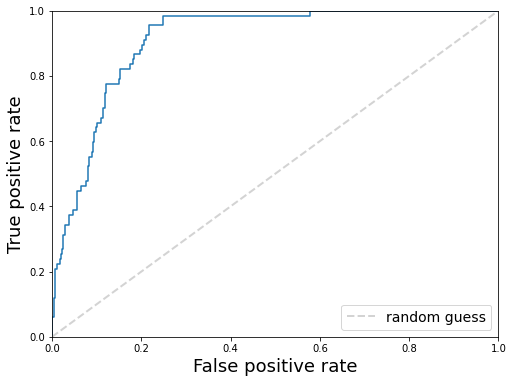

In [24]:
plt.subplots(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, phat)
plt.plot(fpr, tpr)
x = np.linspace(0,1,num=50)
plt.plot(x,x,color='lightgrey',linestyle='--',marker='',lw=2,label='random guess')
plt.legend(fontsize = 14)
plt.xlabel('False positive rate', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


In [25]:
print('AUC is: ', auc(fpr,tpr))

AUC is:  0.9093274547360052


# 이미지 분류

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

In [29]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

In [30]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [31]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [32]:
len(train_set)

60000

9


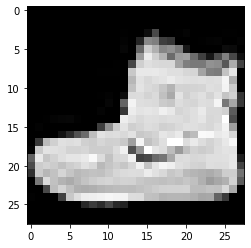

In [33]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [34]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

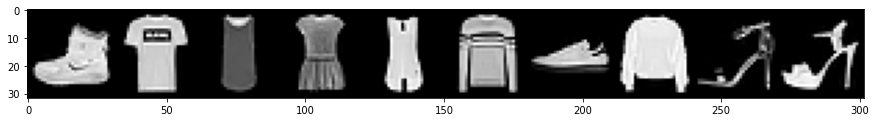

In [35]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [36]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        #out = self.drop(out)
        #out = self.fc2(out)
        #out = self.fc3(out)
        
        return out

In [37]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [38]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 500, Loss: 0.4596560597419739, Accuracy: 88.0999984741211%
Iteration: 1000, Loss: 0.3016437590122223, Accuracy: 89.75%
Iteration: 1500, Loss: 0.25105881690979004, Accuracy: 88.3699951171875%
Iteration: 2000, Loss: 0.1640154868364334, Accuracy: 90.18000030517578%
Iteration: 2500, Loss: 0.134827122092247, Accuracy: 90.61000061035156%
Iteration: 3000, Loss: 0.14067351818084717, Accuracy: 90.43999481201172%


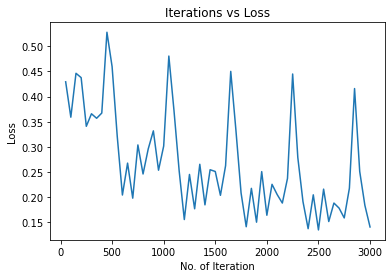

In [39]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

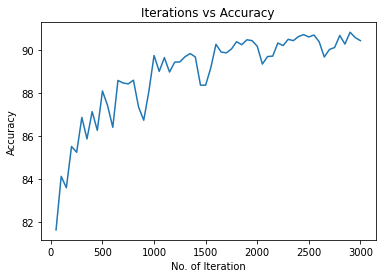

In [40]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [41]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 94.30%
Accuracy of Trouser: 97.40%
Accuracy of Pullover: 81.80%
Accuracy of Dress: 89.90%
Accuracy of Coat: 82.90%
Accuracy of Sandal: 97.70%
Accuracy of Shirt: 69.30%
Accuracy of Sneaker: 94.00%
Accuracy of Bag: 98.80%
Accuracy of Ankle Boot: 98.30%


- ConvLayer
  - Layer 개수, channel 수
- FC Layer
  - Layer 개수, feature 수
- BN
- Pooling Layer
- Optimizer